# The Single Layer Perceptron
In this notebook, we revisit our perceptron model from Lecture 3-2 and apply it to a multi-class problem. This will give us a framework to explore more complex models down the road.

**Learning Objectives**

1. Implement a perceptron for multi-class classifications of multidimensional data.
2. Compute the gradient of a multi-dimensional loss function for use in a perceptron.
3. Implement a single layer perceptron in Python class.

**Import modules**

Begin by importing the modules to be used in this notebook.

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import struct

## The MNIST Dataset
In this notebook, we will examine a dataset of handwritten digits from the Modified National Institute of Standards and Technology (MNIST) dataset. The MNIST Dataset is like the "Hello World" of neural network data.

Let's create a quick function to read in the images and the labels in either the testing or the training data:

In [12]:
def read_mnist_images(subset='train'):
    if subset=='train':
        prefix = 'train-'
    else:
        prefix = 't10k-'
        
    with open(os.path.join('MNIST',prefix+'images.idx3-ubyte'), 'rb') as f:
        # unpack header
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        
        # read image data
        image_data = f.read(num_images * num_rows * num_cols)
        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

    with open(os.path.join('MNIST',prefix+'labels.idx1-ubyte'), 'rb') as f:
        # unpack header
        _, num_labels = struct.unpack('>II', f.read(8))

        # read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

        
    return images, labels

We can use this function as follows:

In [14]:
# load in the training and test images
train_images, train_labels = read_mnist_images(subset='train')
test_images, test_labels = read_mnist_images(subset='test')

# print the sizes
print('Training Image Set Size', np.shape(train_images))
print('Training Labels Set Size', np.shape(train_labels))
print('Testing Image Set Size', np.shape(test_images))
print('Testing Labels Set Size', np.shape(test_labels))

Training Image Set Size (60000, 28, 28)
Training Labels Set Size (60000,)
Testing Image Set Size (10000, 28, 28)
Testing Labels Set Size (10000,)


Let's take a look at what one of these images looks like:

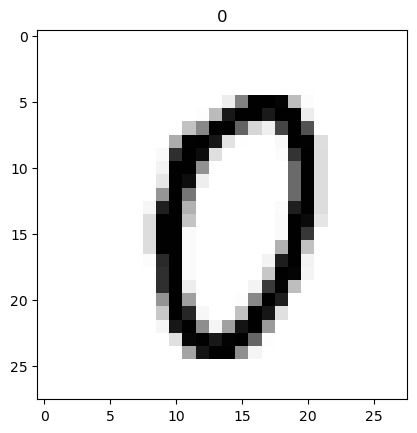

In [15]:
# make a plot here
plt.figure()
plt.imshow(train_images[1000,:,:], cmap='Greys')
plt.title(str(train_labels[1000]))
plt.show()

As we can see, each image is a 28 pixel x 28 pixel image of a hand-written digit.

## The Single-Layer Perception

In our previous lessons on classification, we came across the Perceptron. Here, we will revisit this approach to build a model to classify the images. 

### One-Hot Encoding
In our previous example of a Perceptron, we used a single vector to represent our target classifications (0 for no, 1 for yes). Here, we are going to employ a slightly different encoding called a one-hot encoding. This will be a set of vectors - one for each class - that identify if the image corresponds to that class.

Let's see that works for the first several of our training examples:

In [16]:
# compute the one-hot encoding
one_hot = np.zeros((train_labels.shape[0], 10)).astype(int)
for i,val in enumerate(train_labels):
    one_hot[i, val] = 1

# print the one-hot encoding of the first 5 labels    
print('First 5 labels:')
print(train_labels[:5])

print('\nFirst 5 encodings:')
print(one_hot[:5,:])

First 5 labels:
[5 0 4 1 9]

First 5 encodings:
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


As we can see, the one-hot encoding has a value of 1 corresponding the index of the label 0-9. For example, when the label is 5, all values are 0 except for the value at index 5.

### The Forward Model

In this model formulation, we will create our model to read in an "unraveled" image (or a set of them). That is, instead of reading in images sized 28x28, we will reshape them so that the image sizes are one vector of length 784 (= 28*28). Further, we will normalize the pixel values so that they are in the range 0-1 (rather than 0-255 by default).

In [17]:
# reshape the images to be vectors and normalize the pixel values
X_train = train_images.reshape(-1, 784) / 255.0
X_test = test_images.reshape(-1, 784) / 255.0
Y_train = train_labels
Y_test = test_labels

# print the sizes of the training and validation sets
print('Training Image Set Size: ',np.shape(X_train))
print('Validation Image Set Size: ',np.shape(X_test))
print('Training Label Set Size: ',np.shape(Y_train))
print('Validation Label Set Size: ',np.shape(Y_test))

Training Image Set Size:  (60000, 784)
Validation Image Set Size:  (10000, 784)
Training Label Set Size:  (60000,)
Validation Label Set Size:  (10000,)


Each individual pixel - 784 in total - will be assigned its own individual weight in the network which will be combined in a linear combination along with a bias unit yielding a total of 10 model labels. After these values are determined, the linear combination will be passed to a sigmoid activation function as we saw in our lesson on Logistic Regression to rescale the model output. The following diagram depicts the forward model:

$$
\begin{align*}
z &= Xw^T+b \\ 
p &= \sigma(z)
\end{align*}
$$

<img src="Singlelayer_Perceptron.png" alt="Schematic of a single layer perceptron" width="800">

Here, recall that the sigmoid activation function, applied to $z$ is:

$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

In the implementation here, it is important to note the sizes of each matrix in terms of the rows and columns:

- X: (N, I)
- w: (C, I)
- z: (N, C)
- p: (N, C)

In the schematic above, N=2, C=4, and I=2. In the MNIST image example, N=60000, C=10, and I=784.

Note that there is also a bias vector (one value for each class) that will applied in the linear combination.

### A Note on Neurons
The diagram above is an example of an *artificial neuron* for its relation to how neurons in our human brains operate. Neurons in the brain receive electrical signals (err.. computations) from the nervous system. Based on the character of these signals, a neuron will either "fire" or not - that is, it will either pass on information or it won't. The simple perceptron model replicates this procedure. A set of input data (one row of the image) is passed to the neuron (via a linear combination of weights and the bias) and the activation function determine how the information is passed (in the form of a probability). The output of this neuron is then provided to make a simple decision (not shown above). In this case, the classification will depend on the highest probability value. However, in other applications, the output of the neuron may be passed to other neurons. In this sense, we can build a "neural network" which is composed of a series of perceptron-like models that allow highly non-linear decision making. We'll see an example of this in the notebooks to come. For now, let's take a look at optimizing the weights of our perceptron here. 

### The Loss Function
To compute the optimal weights for our model, we'll need to define a loss function. Here, we will use the mean square error loss function:

$$
L = \frac{1}{NC} \sum_{n=1}^N \sum_{c=1}^C (y_{n,c}-p_{n,c})^2
$$

Here, the loss is computed across all of the $N$ images (60,000 in this case) and all of the $C$ classes (10 in this case).

#### The Derivative of the Loss Function
To use the gradient descent algorithm, we first need to compute the derivatives of the loss function with respect to the weights. Each of our image pixels has a collection of 10 individual weights - one for each of the classifications. This means we will have a 2D matrix of weights, sized (10, 784) in this case).

As we see above, $L$ is a function of $p_{n,c}$ (the probability that the nth image belongs to class $c$) which in turn is a function of the $z_{n,c}$ (the linear model estimate of the nth image for class $c$), which is in turn a function of the weights and the biases. The chain rule provides a way to compute these weights. 

##### A small example
Before deriving the full gradient of the loss function, I find it easiest to consider a smaller example with the shapes shown in the schematic above. Writing out the loss explicitly, we have

$$
\begin{align*}
L = \frac{1}{8} [ &(y_{1,1} - p_{1,1})^2 + (y_{1,2} - p_{1,2})^2 + (y_{1,3} - p_{1,3})^2 + (y_{1,4} - p_{1,4})^2 \\ &(y_{2,1} - p_{2,1})^2 + (y_{2,2} - p_{2,2})^2 + (y_{2,3} - p_{2,3})^2 + (y_{2,4} - p_{2,4})^2]
\end{align*}
$$

Now, considering computing the gradient with respect to a given weight - say $w_{2,3}$  - which is applied to the third index to compute the probability the image belongs to the second class. Looking at the diagram above, we see that that the only $p_{1,2}$ and $p_{2,2}$ depend on this weight, so the gradient becomes

$$
\begin{align*}
\dfrac{\partial L}{\partial w_{2,3}} &= \frac{-2}{8} \left[  (y_{1,2} - p_{1,2}) \frac{\partial p_{1,2}}{\partial z_{1,2}} \frac{\partial z_{1,2}}{\partial w_{2,3}} + (y_{2,2} - p_{2,2}) \frac{\partial p_{2,2}}{\partial z_{2,2}} \frac{\partial z_{2,2}}{\partial w_{2,3}} \right] \\
&= \frac{-2}{8} \left[  (y_{1,2} - p_{1,2}) p_{1,2}(1-p_{1,2})x_{1,3}  + (y_{2,2} - p_{2,2})  p_{2,2}(1-p_{2,2})x_{2,3} \right]
\end{align*}
$$

Note that we are using the following formula derived in Lecture 4-1:

$$
\dfrac{\partial p_{n,c}}{\partial z_{n,c}} = p_{n,c}(1-p_{n,c})
$$

If we define 
$$
\mathcal{D}_{n,c} = -2(y_{n,c} - p_{n,c}) p_{n,c}(1-p_{n,c})
$$

Then we can write this as 
$$
\dfrac{\partial L}{\partial w_{2,3}} = \frac{1}{8} \sum_{n=1}^2 \mathcal{D}_{n,2} x_{n,3}
$$

Generalizing to each of the individual weights, we have

$$
\dfrac{\partial L}{\partial \textbf{w}} = \frac{1}{8}\begin{bmatrix}
\sum_{n=1}^2 \mathcal{D}_{n,1} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{n,1} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{n,1} x_{n,3} \\
\sum_{n=1}^2 \mathcal{D}_{n,2} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{n,2} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{n,2} x_{n,3} \\
\sum_{n=1}^2 \mathcal{D}_{n,3} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{n,3} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{n,3} x_{n,3} \\
\sum_{n=1}^2 \mathcal{D}_{n,4} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{n,4} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{n,4} x_{n,3} 
\end{bmatrix} 
$$

In one more rearrangement, we can write the above matrix as a multiplication of the following:
$$
\dfrac{\partial L}{\partial \textbf{w}} = \begin{bmatrix} \mathcal{D}_{1,1} & \mathcal{D}_{2,1} \\ 
\mathcal{D}_{1,2} & \mathcal{D}_{2,2} \\
\mathcal{D}_{1,3} & \mathcal{D}_{2,3} \\
\mathcal{D}_{1,4} & \mathcal{D}_{2,4} \end{bmatrix} \begin{bmatrix} x_{1,1} & x_{1,2} & x_{1,3} \\ 
x_{2,1} & x_{2,2} & x_{2,3}  \end{bmatrix} = \mathcal{D}^T \textbf{X}
$$



##### Generalizing to an arbitrary size

Using the above framework, we can generalize to an arbitrary number of images $N$, classes $C$ and image length $I$.

Consider a weight $w_{c,i}$ corresponding to class $c$ and pixel $i$. We can express the derivative of the loss function for an individual weight as:

$$
\dfrac{\partial L}{\partial w_{c,i}}  = \frac{-1}{N} \sum_{n=1}^N 2(y_{n,c}-p_{n,c}) p_{n,c}(1-p_{n,c}) x_{n,i}
$$

Here, for simplicity, I will drop the $C$ as it can be ingested as a scalar multiple in the learning rate.

Written out in complete matrix form we can express the full gradient following the structure above:

$$
\begin{align*}
\dfrac{\partial L}{\partial \textbf{w}} &= \frac{-2}{N} \begin{bmatrix} (y_{1,1}-p_{1,1}) p_{1,1}(1-p_{1,1}) & \cdots & (y_{N,1}-p_{N,1}) p_{N,1}(1-p_{N,1}) \\ & \ddots & \\  (y_{1,C}-p_{1,C}) p_{1,C}(1-p_{1,C}) & \cdots & (y_{N,C}-p_{N,C}) p_{N,C}(1-p_{N,C})\end{bmatrix} \begin{bmatrix} x_{1,1} & \cdots & x_{1,I} \\ & \ddots & \\ x_{N,1} & \cdots & x_{N,I}\end{bmatrix} \\  &= \mathcal{D}^T \textbf{X}
\end{align*}
$$

where, again for clarity, here we have defined the following matrix:
$$
\mathcal{D} = \frac{-2}{N} \begin{bmatrix} (y_{1,1}-p_{1,1}) p_{1,1}(1-p_{1,1}) & \cdots & (y_{1,C}-p_{1,C}) p_{1,C}(1-p_{1,C}) \\ & \ddots & \\   (y_{N,1}-p_{N,1}) p_{N,1}(1-p_{N,1}) & \cdots & (y_{N,C}-p_{N,C}) p_{N,C}(1-p_{N,C})\end{bmatrix}
$$

In a similar sense, we can write the derivative of the loss function with respect to $\textbf{b}$ as 

$$
\begin{align*}
\dfrac{\partial L}{\partial \textbf{b}} &= \frac{-2}{N} \begin{bmatrix} (y_{1,1}-p_{1,1}) p_{1,1}(1-p_{1,1}) & \cdots & (y_{N,1}-p_{N,1}) p_{N,1}(1-p_{N,1}) \\ & \ddots & \\  (y_{1,C}-p_{1,C}) p_{1,C}(1-p_{1,C}) & \cdots & (y_{N,C}-p_{N,C}) p_{N,C}(1-p_{N,C})\end{bmatrix} \begin{bmatrix} 1 \\ \vdots \\ 1 \end{bmatrix} \\  &= \mathcal{D}^T \textbf{1}
\end{align*}
$$

## Coding Up a Solution
Now that we know how to compute our gradients, let's write some code to create our model!

In [18]:
class SingleLayerPerceptron:

    def __init__(self, num_features, num_classes, random_seed=123):

        self.num_classes = num_classes
        generator = np.random.RandomState(random_seed)
        self.weight_out = generator.normal(loc=0.0, scale=0.1, size=(num_classes, num_features))
        self.bias_out = np.zeros(num_classes)

    def int_to_onehot(self, y, num_labels):
        ary = np.zeros((y.shape[0], num_labels))
        for i, val in enumerate(y):
            ary[i, val] = 1
        return(ary)

    def sigmoid(self,z):
        return (1/(1+np.exp(-z)))

    # EDIT: define the forward function
    def forward(self, x):
        z = np.dot(x, self.weight_out.T)+self.bias_out
        p = self.sigmoid(z)
        return(p)


    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    # EDIT: define the backward function
    def backward(self, x, p, y):
        y_onehot = self.int_to_onehot(y, self.num_classes)

        d_L__d_p = -2*(y_onehot - p)/y.shape[0]

        d_p__d_z = p*(1-p)

        D = d_L__d_p * d_p__d_z

        d_L__d_w = np.dot(D.T, x)

        d_L__d_b = np.dot(D.T, np.ones((x.shape[0],)))

        return(d_L__d_w, d_L__d_b)


    def mse_loss(targets, probs, num_labels=10):
        onehot_targets = int_to_onehot(targets, num_labels)
        err = np.mean((onehot_targets - probs)**2)
        return(err)

    def compute_mse_and_acc(self, X, y, num_labels=10):
        probs = self.forward(X)
        predicted_labels = np.argmax(probs,axis=1)
        onehot_targets =self.int_to_onehot(y, num_labels)
        loss = np.mean((onehot_targets - probs)**2)
        acc = np.sum(predicted_labels == y)/len(y)
        return(loss, acc)

    def train(self,X_train, Y_train, X_test, Y_test, num_epochs, learning_rate=0.1):
        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        for e in range(num_epochs):
            a_out = self.forward(X_train)

            # EDIT: comput the gradients and update the weights and biases
            d_L__d_w, d_L__d_b = self.backward(X_train, a_out, Y_train)
            self.weight_out -= d_L__d_w * learning_rate
            self.bias_out -= d_L__d_b * learning_rate

            train_loss, train_acc = self.compute_mse_and_acc(X_train, Y_train)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            test_loss, test_acc = self.compute_mse_and_acc(X_test, Y_test)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
        return(train_losses, train_accs, test_losses, test_accs)

### Using the Perceptron Model
Now that we've got the model coded up, let's train it and use it to classify the images. First, let's train the model.

In [19]:
# implement and train the model
slp = SingleLayerPerceptron(784, 10)
train_losses, train_accs, test_losses, test_accs = \
   slp.train(X_train, Y_train, X_test, Y_test, 1000, learning_rate=0.5)

As always, we should take a look at the loss functions through the training process:

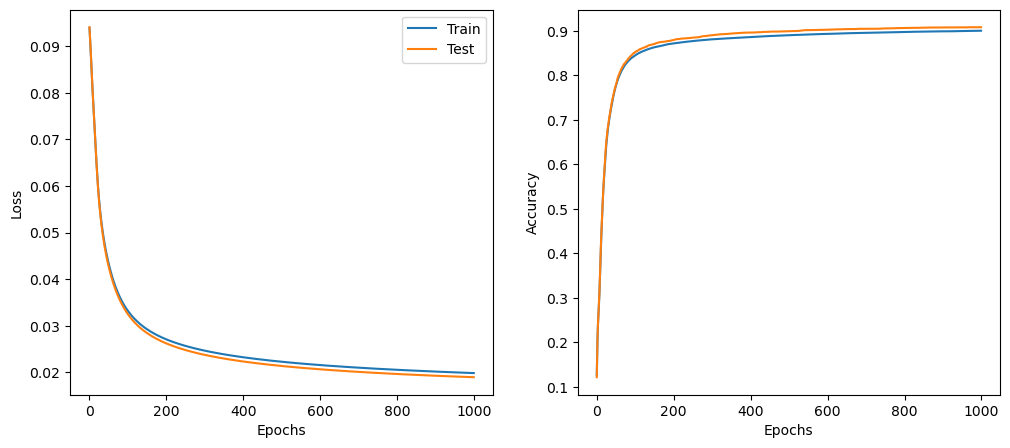

In [14]:
# plot the losses and accuracies

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs)
plt.plot(test_accs)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()


With more than 1000 iterations and a learning rate of 0.5, our model has now started to converge.

Let's see how it has works on a collection of random images:

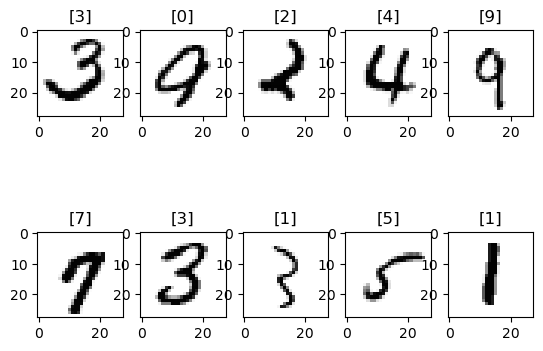

In [20]:
# choose a set of indices 
np.random.seed(37)
test_indices = np.random.randint(low=0, high=10000, size=10)

# make a plot of the predictions
for d, index in enumerate(test_indices):
    plt.subplot(2,5, d+1)
    plt.imshow(train_images[index,:,:], cmap='Greys')
    image_prediction = slp.predict(train_images[index, : ,:].reshape((1, 784))/255.0)
    plt.title(str(image_prediction))

plt.show()

Not bad! But can we do better? Let's see in the next notebook!